## Building the graph

### Clipping: All except colabs mentioning "python" + Colabs mentioning only "Javascript"

After getting and parsing the data, we need to understand and create metrics that could lead us to our hypothesis and it's impacts.

In [143]:
from netpixi.integration.gt import Graph
import pandas as pd
import numpy as np

g = Graph(directed=False)

In [144]:
data = pd.read_csv("../data/colaboration_comments.csv")

In [145]:
# Add the source repositories (usually belonging to organizations where users collaborate)
data['source'] = list(map(lambda x : x.split("https://github.com/")[-1].split('/')[0],data['URL']))

In [146]:
#All except colabs mentioning "python" + Colabs mentioning only "Javascript"
data = data[data['BODY'].notna() & ~data['BODY'].str.lower().apply(lambda x: 'python' in str(x).lower() or 'py' in str(x).lower())]
data = data[data['BODY'].notna() & data['BODY'].str.lower().str.contains('javascript|js',case=False)]

In [147]:
# Drop columns which we won't use
data = data.drop(['COMMIT_ID','COMMENT_ID','URL'],axis=1)

In [148]:
#First view of data
data

,AUTHOR,CREATED_AT,BODY,source
22,orenyk,2015-01-01T00:13:41Z,any reason why we're not excluding `vendor` he...,YaleSTC
33,jc00ke,2015-01-01T00:18:37Z,"```ruby\r\nbody = {\r\n name: ""event"",\r\n s...",botandrose
42,codeschool-kiddo,2015-01-01T00:22:52Z,Looks good! Could you also please mention your...,deadlyvipers
45,mnquintana,2015-01-01T00:23:59Z,It seemed to be a bug with jshint's globbing -...,YaleSTC
56,jbrooksuk,2015-01-01T00:29:06Z,Move the JS into start.js please.,Jamesking56
...,...,...,...,...
635061,kuba,2015-02-28T08:30:06Z,That's because we want to use `cls.from_valid_...,letsencrypt
635113,mrjoelkemp,2015-02-28T08:43:50Z,What about 'index.js' as a path? Wouldn't that...,mrjoelkemp
635126,rexxarM,2015-02-28T08:48:18Z,@kennytm does iOS support this way to invoke ...,hihex
635146,kennytm,2015-02-28T08:55:51Z,iOS WebView supports this if the via URL captu...,hihex


In [149]:
#Looking to the total contribuitions for the users in the source repositories
total_contributions = data.groupby(['AUTHOR']).count()['source'].sort_values(ascending=False)
total_contributions

AUTHOR
codeschool-kiddo    768
linthubot           332
vladberteanu         60
bajtos               58
sindresorhus         58
                   ... 
github-tn             1
gitblit               1
giosh94mhz            1
gilmoskowitz          1
zzcclp                1
Name: source, Length: 6655, dtype: int64

In [150]:
# As we can see there are many contribuitors who participated much less than the average, we're going to use this to filter 
# the data: contribuitors who has less contributions than the average will not be considered for the network
total_contributions.describe()

count    6655.000000
mean        2.532983
std        10.835107
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       768.000000
Name: source, dtype: float64

In [151]:
#Cleaning the data as explaneid above
contribuitors = data.groupby(['source']).count()['AUTHOR'].sort_values(ascending=False)
contribuitors_mean = contribuitors.mean()
repos_edge = contribuitors[contribuitors>contribuitors_mean]
repos_edge.index

Index(['deadlyvipers', 'mozilla', 'iojs', 'nl5887', 'mozilla-b2g', 'edx',
       'angular', 'Wikia', 'jquery', 'jscs-dev',
       ...
       'josdejong', 'ogawatti', 'webgme', 'SuaveIO', 'Tatoeba', 'mciruzzi',
       'Icenium', 'ReadyTalk', '4teamwork', 'mdx-dev'],
      dtype='object', name='source', length=858)

In [152]:
#filtering
data_clean = data[data['source'].isin(repos_edge.index)]

In [153]:
data_clean

,AUTHOR,CREATED_AT,BODY,source
22,orenyk,2015-01-01T00:13:41Z,any reason why we're not excluding `vendor` he...,YaleSTC
42,codeschool-kiddo,2015-01-01T00:22:52Z,Looks good! Could you also please mention your...,deadlyvipers
45,mnquintana,2015-01-01T00:23:59Z,It seemed to be a bug with jshint's globbing -...,YaleSTC
298,bors-servo,2015-01-01T10:00:43Z,merging yodalee/servo/issue4484-ToJSValConvert...,servo
299,bors-servo,2015-01-01T10:00:44Z,yodalee/servo/issue4484-ToJSValConvertible-for...,servo
...,...,...,...,...
634903,Honry,2015-02-28T07:16:45Z,"This step name elusive, here you want to click...",crosswalk-project
634934,cpq,2015-02-28T07:31:52Z,Dead code removed.\r\nJS implementation is wro...,cesanta
635061,kuba,2015-02-28T08:30:06Z,That's because we want to use `cls.from_valid_...,letsencrypt
635113,mrjoelkemp,2015-02-28T08:43:50Z,What about 'index.js' as a path? Wouldn't that...,mrjoelkemp


We already have the filter to build the network with a good context to define an edge between two collaborators: 

**There are an edge between them if they have at least one collaboration in a relevant source**

Even so, there many developers who collaborate very little, and we need to adjust our data to maintain only developers with a appropriate average frequency in mass of data to avoid any bias due collators with less interactions than the average of collaborations.

In [154]:
#Contributions to define an edge
edge_contrib = data_clean.groupby(['AUTHOR']).count()['source'].sort_values(ascending=False)
#Average contributions
average_contrib =edge_contrib.mean()
#Filtering
above_average_contrib = edge_contrib[edge_contrib>average_contrib]
data_clean = data_clean[data_clean['AUTHOR'].isin(above_average_contrib.index)]
authors = data_clean.groupby(['AUTHOR']).count()['source'].sort_values(ascending=False)
data_clean

,AUTHOR,CREATED_AT,BODY,source
22,orenyk,2015-01-01T00:13:41Z,any reason why we're not excluding `vendor` he...,YaleSTC
42,codeschool-kiddo,2015-01-01T00:22:52Z,Looks good! Could you also please mention your...,deadlyvipers
298,bors-servo,2015-01-01T10:00:43Z,merging yodalee/servo/issue4484-ToJSValConvert...,servo
299,bors-servo,2015-01-01T10:00:44Z,yodalee/servo/issue4484-ToJSValConvertible-for...,servo
346,vme-odoo,2015-01-01T10:35:29Z,"Hi @mba-odoo, in website_snippet_editor.js you...",odoo
...,...,...,...,...
634855,kkasravi,2015-02-28T06:54:29Z,I've defined a services.js which adds the the ...,intel-hadoop
634856,kkasravi,2015-02-28T06:54:30Z,Added this in services.js prior to the Streami...,intel-hadoop
634934,cpq,2015-02-28T07:31:52Z,Dead code removed.\r\nJS implementation is wro...,cesanta
635113,mrjoelkemp,2015-02-28T08:43:50Z,What about 'index.js' as a path? Wouldn't that...,mrjoelkemp


## Defining focus

We now need to define a custom metric to help to define our hypothesis: 

**As much a developers belong to a community (obtained by cluster coefficient metric), he has focus in the collaborations**

That way we need to define the concept of focus. Focus will be understanding in this context by: 

*Number of developer collaborations considered for edge formation divided per total collaborations in the data, thoughtful by the Number of developer collaborations per the max Number of collaborations of an individual:*

 $$focus = \frac{edgeContributions_i}{totalContributions_i}\cdot\frac{edgeContributions_i}{maxEdgeContribution}$$
 
 This metric is interesting because as define the percentage of relevant contributions to the graph, it takes into account the quantity of the individual contributions of the developer, giving different weights to them, even the  percentage of relevant contributions is similar, deepening the relevance of this metric.

In [155]:
focus = (edge_contrib/total_contributions)*(edge_contrib/np.max(edge_contrib))
focus = focus.dropna().sort_values(ascending=True)
focus

AUTHOR
shinnn              0.000163
phated              0.000260
splendido           0.000260
swannodette         0.000326
bendrucker          0.000326
                      ...   
sindresorhus        0.070402
bajtos              0.070402
vladberteanu        0.078125
linthubot           0.424514
codeschool-kiddo    1.000000
Name: source, Length: 3341, dtype: float64

## Building the Network properly

To the define the network we need to enumerate the collaborators who interact in the same repo by repo, and after it set pairs of developers to create an edge in the network. 

Concurrently we are defining the focus of each developer.

In [156]:
same_repo_colab = data_clean.groupby('source')['AUTHOR'].apply(lambda x: list(np.unique(x)))
same_repo_colab

source
18F                                  [msecret]
201-created                           [bantic]
2600hz                        [jamesaimonetti]
28msec                            [wcandillon]
3y3                              [3y3, bajtos]
                             ...              
zendframework                       [Ocramius]
zestedesavoir                         [Alex-D]
zlenyk                                [Anitka]
zotero           [aurimasv, rmzelle, zuphilip]
zxqfox                         [eGavr, zxqfox]
Name: AUTHOR, Length: 601, dtype: object

In [157]:
import itertools
import warnings
warnings.filterwarnings('ignore') 

g.add_vp('focus')
g.add_vp('colabs')
for index, row in same_repo_colab.iteritems():
    pairs = itertools.combinations(row, 2)
    for i,pair in enumerate(pairs):
        try:
            g.add_vertex(pair[0])
            u = g.get_vertex(pair[0])
            u['focus'] = focus[pair[0]]
            u['colabs'] = int(edge_contrib[pair[0]])
        except Exception as inst:
            pass
        try:
            g.add_vertex(pair[1])
            v = g.get_vertex(pair[1])
            v['focus'] = focus[pair[1]]
            v['colabs'] = int(edge_contrib[pair[1]])
        except Exception as inst:
            pass
        finally:
            try:
                g.add_edge(pair[0],pair[1])
            except:
                pass

#### Number of vertex in the graph

In [158]:
n = g.num_vertices()
print("g's number of vertex:", n)

g's number of vertex: 641


#### Number of edges in the graph

In [159]:
m = g.num_edges()
print("g's number of edges:", m)

g's number of edges: 3068


#### Density of the graph

In [160]:
if g.is_directed():
    max_edges = n * (n - 1)
else:
    max_edges = n * (n - 1) // 2
max_edges

205120

In [161]:
d = m / max_edges
d
print(f'Density is {d}')

Density is 0.014957098283931358


### Analyzing the graph

After obtained the general data of the graph, we need to create insights by regression details which describes better if our hypothesis will be confirmed or not.

In [162]:
import seaborn as sns
from netpixi.integration.gt import *
from regression.integration.gt import *

In [163]:
data = gt_data(g)
data.head(5)

,focus,colabs
id,,
3y3,0.005208,4
bajtos,0.070402,56
chicoxyzzy,0.005208,4
jridgewell,0.010547,9
sebmck,0.032552,25


##### Adding clustering and degree metrics

In [164]:
from graph_tool import clustering

lc = clustering.local_clustering(g)
g.add_vp('clustering', lc)
dc = gt_total_degree(g)
g.add_vp('degree', dc)
data = gt_data(g)
data.describe()

,focus,colabs,clustering,degree
count,641.000000,641.000000,641.000000,641.000000
mean,0.011042,8.862715,0.706567,0.014957
std,0.009107,7.257746,0.419903,0.018967
min,0.002604,4.000000,0.000000,0.001563
25%,0.005208,5.000000,0.333333,0.003125
50%,0.007812,6.000000,1.000000,0.006250
75%,0.013021,10.000000,1.000000,0.018750
max,0.070402,56.000000,1.000000,0.107813


In [165]:
degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())
data['degree_count'] = degrees
data['degree_count'].describe().to_frame()

,degree_count
count,641.000000
mean,9.572543
std,12.138580
min,1.000000
25%,2.000000
50%,4.000000
75%,12.000000
max,69.000000


<AxesSubplot: xlabel='degree_count', ylabel='Count'>

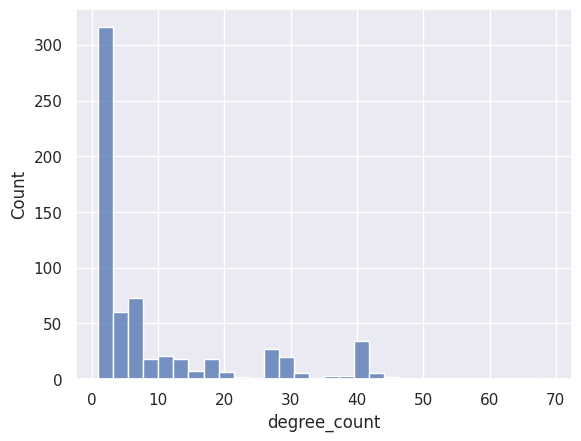

In [166]:
sns.histplot(data['degree_count'])

#### Dropping the outliers (colabs > 1000)

As we can see above there collaborators who are much higher than the collaborations, and much of them are bot's accounts (e.g *houndci* and *nrel-bot*). For this, we're removing them for the analysis.

In [167]:
selRows = data[data['colabs'] > 400].index
data = data.drop(selRows,axis=0)

### Normalizing focus

After removing the outliers we need to normalize the focus metric to properly give insights about the data.

In [168]:
x = data['focus']
x_norm = (x-np.min(x))/(np.max(x)-np.min(x)) + 1e-10 #For log issues in the next cells
data['focus'] = x_norm

In [169]:
data['degree'].describe().to_frame()

,degree
count,641.000000
mean,0.014957
std,0.018967
min,0.001563
25%,0.003125
50%,0.006250
75%,0.018750
max,0.107813


In [170]:
data['focus'].describe().to_frame()

,focus
count,6.410000e+02
mean,1.244563e-01
std,1.343324e-01
min,1.000000e-10
25%,3.841060e-02
50%,7.682119e-02
75%,1.536424e-01
max,1.000000e+00


### Regression 

<AxesSubplot: xlabel='focus', ylabel='Count'>

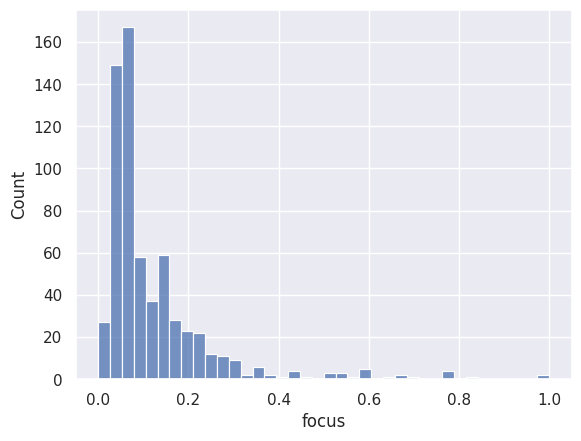

In [171]:
sns.histplot(data['focus'])

<AxesSubplot: xlabel='degree', ylabel='Count'>

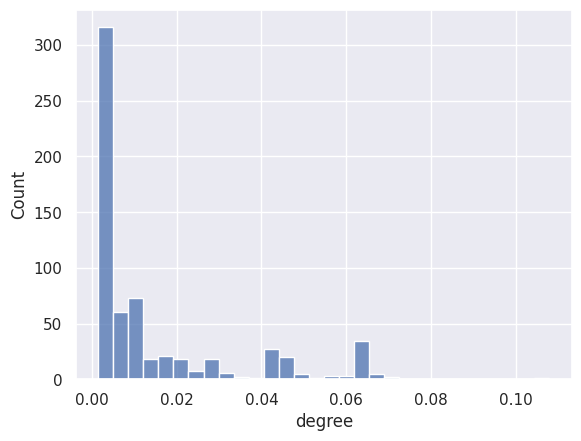

In [172]:
sns.histplot(data['degree'])

In [173]:
import seaborn as sns
import regression as reg

from scipy import stats
from matplotlib import pyplot as plt

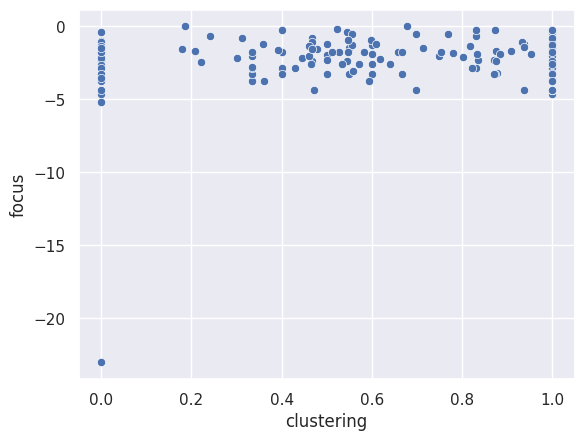

In [174]:
sns.scatterplot(x=data['clustering'], y=np.log(data['focus']));

In [175]:
data.sort_values(by="focus",ascending=False)

,focus,colabs,clustering,degree,degree_count
id,,,,,
bajtos,1.000000e+00,56,0.677778,0.056250,36
sindresorhus,1.000000e+00,56,0.184685,0.057813,37
zxqfox,8.292170e-01,48,0.523810,0.023438,15
stvstnfrd,7.874172e-01,43,0.831579,0.031250,20
houndci,7.743576e-01,46,1.000000,0.006250,4
...,...,...,...,...,...
stoeffel,9.602649e-03,5,0.000000,0.001563,1
ajoslin,9.602649e-03,5,1.000000,0.018750,12
jrick,5.487228e-03,4,0.000000,0.001563,1


### Residuals

In [176]:
result = reg.linear(data=data, formula='focus ~ clustering')

In [177]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  focus   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                 0.0004752
Date:                Thu, 08 Jun 2023   Prob (F-statistic):              0.983
Time:                        19:56:27   Log-Likelihood:                 377.73
No. Observations:                 641   AIC:                            -751.5
Df Residuals:                     639   BIC:                            -742.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1247      0.010     11.986      0.000       0.104       0.145
clustering    -0.0003      0.013     -0.022      0.983      -0.025       0.025
==============================================================================
Omnibus:                      440.768   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4654.368
Skew:                           3.054   Prob(JB):                         0.00
Kurtosis:                      14.703   Cond. No.                         3.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [178]:
result.micro_summary()

variable,coefficient,std error,p-value
clustering,-0.000276,0.012656,0.982615


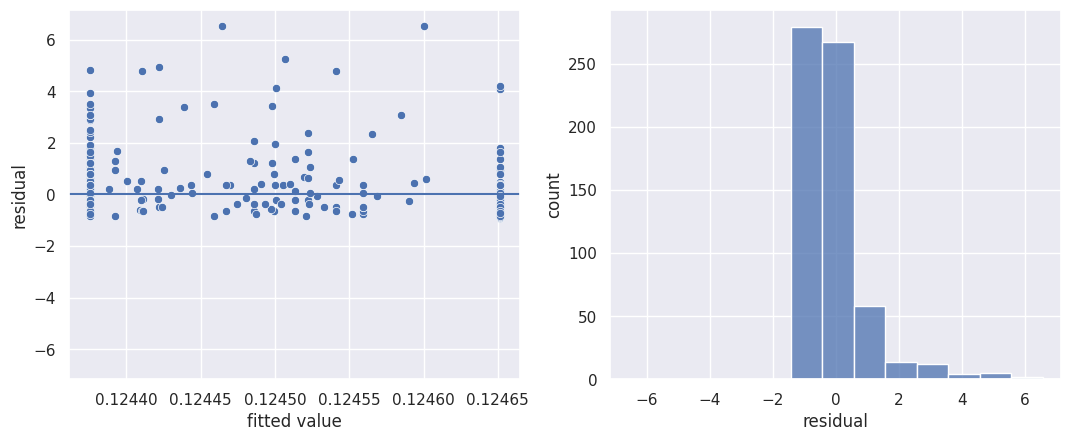

In [179]:
result.plot_residuals()

#### "Massaging" the data

As we can see, the distribution of residuals is not good as we want, because the residuals has not a randomic and normal distribution to give the give the necessary confidence to the model. 

Because of this, we can apply a logaritmic scale to the focus to get a better shape and use the degree as control variable (which means the quantity of neighbors of the vertex).

In [180]:
result = reg.linear(data=data, formula='np.log(focus) ~ clustering + degree')

In [181]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(focus)   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     4.873
Date:                Thu, 08 Jun 2023   Prob (F-statistic):            0.00794
Time:                        19:56:29   Log-Likelihood:                -999.04
No. Observations:                 641   AIC:                             2004.
Df Residuals:                     638   BIC:                             2017.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6228      0.090    -29.191      0.000      -2.799      -2.446
clustering     0.0460      0.115      0.400      0.690      -0.180       0.272
degree         7.0998      2.546      2.789      0.005       2.100      12.099
==============================================================================
Omnibus:                      996.787   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           631860.552
Skew:                          -8.607   Prob(JB):                         0.00
Kurtosis:                     155.845   Cond. No.                         69.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [182]:
result.micro_summary()

variable,coefficient,std error,p-value
clustering,0.045960,0.115000,0.689547
degree,7.099810,2.545991,0.005451


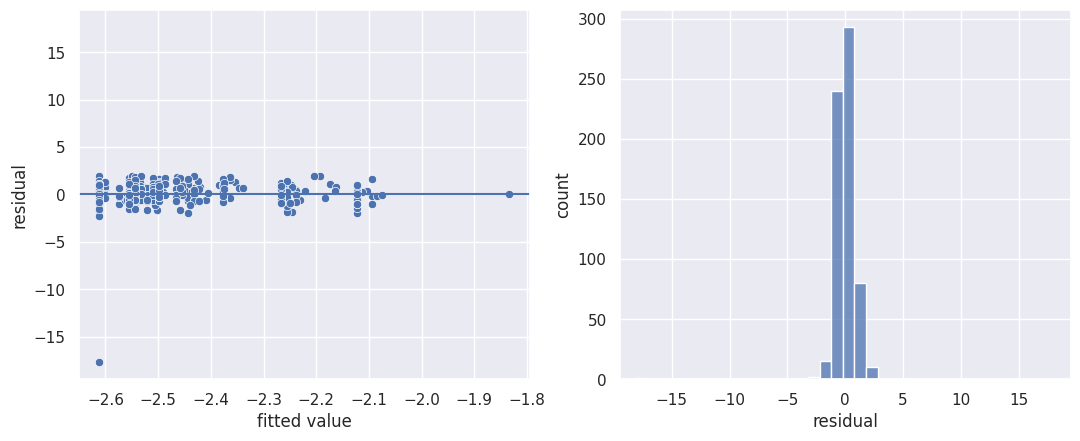

In [183]:
result.plot_residuals()

## Saving the graph

In [141]:
import netpixi

In [142]:
gt_save(g, '../networks/colabs_except_python_only_js.net.gz')